# Подготовка модели распознавания рукописных букв и цифр

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor, Compose, Normalize, transforms

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
dataset = EMNIST('data/', 'balanced', download=False)
dataset

Dataset EMNIST
    Number of datapoints: 112800
    Root location: data/
    Split: Train

In [3]:
# посмотрим на словарь метка-символ

emnist_map = {}
with open('emnist-balanced-mapping.txt', 'r') as file:
    for line in file:
        label, code = line.split()
        emnist_map[int(label)] = chr(int(code))

emnist_map

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [4]:
# посмотрим на изображения

for i in range(10):
    img, label = dataset[i]
    print(label, emnist_map[label])
    display(img)

# можно заметить, что ориентация символов некорректная

45 r


36 a


43 n


15 F


4 4


42 h


26 Q


32 W


20 K


1 1


### Предобработка изображений

In [5]:
def rotate(image):
    
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    
    return image

In [6]:
# Создаём новую трансформацию
class RotateTransform:
    def __call__(self, image):
        image = np.array(image)  # Преобразуем в numpy
        image = rotate(image)  # Применяем функцию поворота
        return transforms.ToTensor()(image)  # Преобразуем обратно в тензор


In [7]:
# приведем изображения PIL.Image в тензоры
# и отцентрируем и отнормируем данные, чтобы на вход модели приходили числа от −1 до 1

transform = Compose([
    ToTensor(),  # преобразуем изображение в тензор (авто / 255)
    RotateTransform(),  # применяем функцию поворота
    Normalize([0.5], [0.5])  # масштабируем в [-1, 1]
])

train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
test_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)

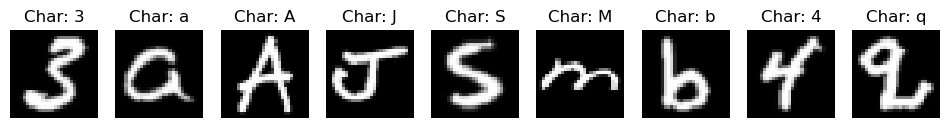

In [8]:
# убедимся, что теперь изображения имеют корректную ориентацию

# функция для отображения нескольких изображений
def show_images(dataset, num_images=9):
    fig, axes = plt.subplots(1, num_images , figsize=(12, 3))

    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))  
        image, label = dataset[idx]  
        image = image.squeeze(0).numpy()  # убирем лишний канал (1, 28, 28) -> (28, 28)
        
        axes[i].imshow(image, cmap='gray')  
        axes[i].set_title(f"Char: {emnist_map[label]}")  
        axes[i].axis("off")

    plt.show()

show_images(train_dataset)

In [9]:
# определим размер train и val
train_size = int(0.8 * len(train_dataset))  # 80% данных для train
val_size = len(train_dataset) - train_size  # 20% данных для val

# разобьем датасет на train и val
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [11]:
# оборачиваем в DataLoader, чтобы получить итерируемый объект и позаботиться о группировке семплов в батчи

train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### CNN

In [12]:
for data, target in train_dataloader:
    print(data.shape)  
    break

torch.Size([256, 1, 28, 28])


In [36]:
# функция оценки работы модели
def evaluation(model, dataloader):
    model.eval()  # Отключаем dropout и batchnorm (если есть)
    loss_sum = 0
    correct = 0

    for step, (data, target) in enumerate(dataloader):
        with torch.no_grad(): 
            target = target.long()  # Преобразуем метки в long (для CrossEntropyLoss)
            
            output = model(data)
            
            loss = loss_f(output, target)

        loss_sum += loss.item()

        prediction = output.argmax(dim=1, keepdim=True) # находим индекс макс элемента – это и есть метка класса 

        correct += prediction.eq(target.view_as(prediction)).sum().item()

    accuracy = correct / len(dataloader.dataset)
    loss = loss_sum / (step + 1) 
    
    return loss, accuracy
    

# функция обучения модели
def train(model, train_dataloader, val_dataloader, optimizer, loss_f, n_epochs, scheduler, best_model_path, patience=5):
    val_loss_list, val_acc_list = [], []
    train_loss_list, train_acc_list = [], []

    early_stop_counter = 0  # Счётчик для early stopping
    best_loss = float('inf')  
    
    model.train()
    for epoch in range(n_epochs):
        loss_sum = 0
        
        for step, (data, target) in enumerate(train_dataloader):
            target = target.long()  # Преобразуем метки в long (для CrossEntropyLoss)
            
            optimizer.zero_grad() # зануляем градиенты

            output = model(data) # логиты

            loss = loss_f(output, target)
            loss.backward()

            optimizer.step()

            loss_sum += loss.item()

        print(f'Epoch: {epoch}, \tMean_Train_Loss: {loss_sum / (step + 1):.6f}')

        # записываем результаты оценки модели для тренировочной и валидационной выборок
        train_loss, train_accuracy = evaluation(model, train_dataloader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)
        
        val_loss, val_accuracy = evaluation(model, val_dataloader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)
        print(f'Val_Loss: {val_loss:.6f}, \tVal_Accuracy: {val_accuracy:.6f}\n')  

        # проверка early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0  # Сбрасываем счётчик
            torch.save(model.state_dict(), best_model_path)  # Сохраняем веса лучшей модели
        else:
            early_stop_counter += 1  # Увеличиваем счётчик
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Обновляем scheduler (уменьшаем LR, если val_loss не падает)
        scheduler.step(val_loss)
        
    return val_loss_list, val_acc_list, train_loss_list, train_acc_list


# график потерь (Loss) и график точности (Accuracy)
def val_loss_accuracy_plot(val_loss_list, val_acc_list, train_loss_list, train_acc_list):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # график Loss 
    axs[0].plot(range(len(train_loss_list)), train_loss_list, label="Train Loss", color='blue')
    axs[0].plot(range(len(val_loss_list)), val_loss_list, label="Validation Loss", color='red')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Model Loss per Epoch')
    axs[0].grid(True)
    axs[0].legend()

    # график Accuracy 
    axs[1].plot(range(len(train_acc_list)), train_acc_list, label="Train Accuracy", color='blue')
    axs[1].plot(range(len(val_acc_list)), val_acc_list, label="Validation Accuracy", color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Model Accuracy per Epoch')
    axs[1].grid(True)
    axs[1].legend()

    plt.show()

In [32]:
class EMNIST_3CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # [B, 1, 28, 28] -> [B, 32, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # [B, 32, 28, 28] -> [B, 32, 14, 14]

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # [B, 32, 14, 14] -> [B, 64, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # [B, 64, 14, 14] -> [B, 64, 7, 7]

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Уменьшаем размерность в 2 раза
            
            nn.Flatten(), # [B, 64, 7, 7] -> [B, 64*7*7]
            
            nn.Linear(in_features=1152, out_features=64), 
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )

    def forward(self, x):
        return self.model(x)

In [33]:
net = EMNIST_3CNN(n_classes=47)
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
EMNIST_3CNN                              [1, 47]                   --
├─Sequential: 1-1                        [1, 47]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [1, 128, 7, 7]            --
│    └─MaxPool2d: 2-9                    [1, 128, 3, 3]            --
│    └─Flatten: 2-10                     [1, 1152]                 --
│    └─Linear: 2-11                      [1, 64]                   73,792
│ 

In [37]:
model = EMNIST_3CNN(n_classes=47)

loss_f = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#print(f"Before scheduler step: {scheduler.get_last_lr()}\n") 

n_epochs = 50
patience = 10
best_model_path = os.path.join('myapp', 'best_model3CNN.ckpt') 

val_loss_list, val_acc_list, train_loss_list, train_acc_list = train(model, train_dataloader, val_dataloader, 
                                                                     optimizer, loss_f, n_epochs, scheduler, best_model_path, patience)
test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f'Test_Loss: {test_loss}, \tTest_Accuracy: {test_accuracy:.6f}\n')  

#print(f"After scheduler step: {scheduler.get_last_lr()}")

Epoch: 0, 	Mean_Train_Loss: 2.100153
Val_Loss: 0.806282, 	Val_Accuracy: 0.734043

Epoch: 1, 	Mean_Train_Loss: 0.589790
Val_Loss: 0.516980, 	Val_Accuracy: 0.826152

Epoch: 2, 	Mean_Train_Loss: 0.463348
Val_Loss: 0.517470, 	Val_Accuracy: 0.823848

Epoch: 3, 	Mean_Train_Loss: 0.410069
Val_Loss: 0.424920, 	Val_Accuracy: 0.852881

Epoch: 4, 	Mean_Train_Loss: 0.377554
Val_Loss: 0.430719, 	Val_Accuracy: 0.849645

Epoch: 5, 	Mean_Train_Loss: 0.354159
Val_Loss: 0.428212, 	Val_Accuracy: 0.851507

Epoch: 6, 	Mean_Train_Loss: 0.334673
Val_Loss: 0.405244, 	Val_Accuracy: 0.852704

Epoch: 7, 	Mean_Train_Loss: 0.319339
Val_Loss: 0.380747, 	Val_Accuracy: 0.865514

Epoch: 8, 	Mean_Train_Loss: 0.307399
Val_Loss: 0.385063, 	Val_Accuracy: 0.858067

Epoch: 9, 	Mean_Train_Loss: 0.295990
Val_Loss: 0.402069, 	Val_Accuracy: 0.862234

Epoch: 10, 	Mean_Train_Loss: 0.285912
Val_Loss: 0.362442, 	Val_Accuracy: 0.875532

Epoch: 11, 	Mean_Train_Loss: 0.276355
Val_Loss: 0.374152, 	Val_Accuracy: 0.864450

Epoch: 12, 	Me

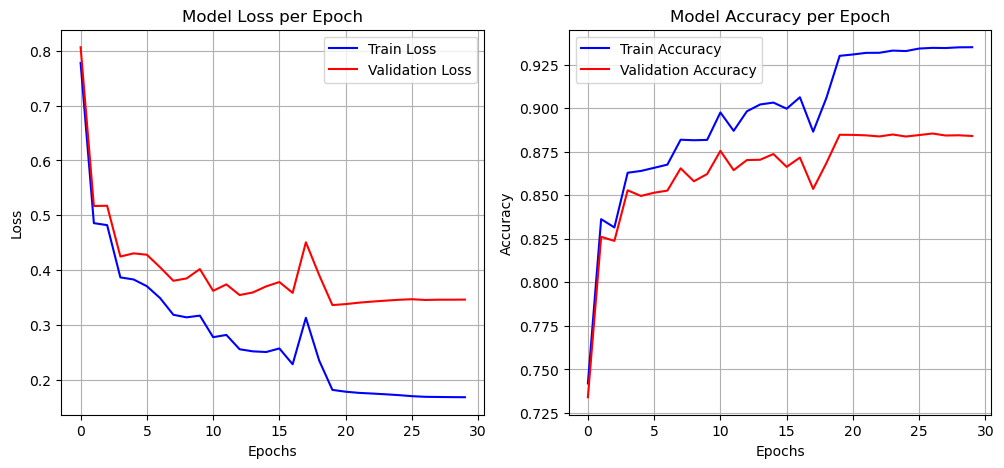

In [38]:
# посмотрим на графики 

val_loss_accuracy_plot(val_loss_list, val_acc_list, train_loss_list, train_acc_list)  

In [39]:
# проверим, что модель корректно загружается

# создаем модель
model3CNN = EMNIST_3CNN(n_classes=47)

# загружаем веса в модель
model3CNN.load_state_dict(torch.load(best_model_path, weights_only=True))

<All keys matched successfully>

In [40]:
test_loss, test_accuracy = evaluation(model3CNN, test_dataloader)
print(f'Best model: \nTest_Loss: {test_loss}, \tTest_Accuracy: {test_accuracy:.6f}\n')  

Best model: 
Test_Loss: 0.3508078778112257, 	Test_Accuracy: 0.882979

